In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import anndata2ri
import gdown
import scipy
import scipy.io
from rpy2.robjects import r

anndata2ri.activate()

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
suppressPackageStartupMessages({
    library(SingleCellExperiment)
    library(Seurat)
    library(SeuratDisk)
    library(Signac)
})

# Expressions

## Download the data

In [4]:
gdown.download(
    'https://drive.google.com/uc?id=1E3AT2wztvswn3p_N5kWEmk0_ZHaT3OWH',
    'chen2019-expressions.h5ad'
)

Downloading...
From: https://drive.google.com/uc?id=1E3AT2wztvswn3p_N5kWEmk0_ZHaT3OWH
To: /mnt/home/icb/anastasia.litinetskaya/multigrate/example/chen2019-expressions.h5ad
9.00MB [00:00, 83.4MB/s]


'chen2019-expressions.h5ad'

In [5]:
adata = sc.read('chen2019-expressions.h5ad')

In [6]:
adata_ = ad.AnnData(adata.layers['count'])
adata_.obs_names = adata.obs_names
adata_.var_names = adata.var_names
adata_.obs['cell_type'] = adata.obs['cell_type']

In [7]:
%%R -i adata_
rna = as.Seurat(adata_, counts='X', data=NULL)
rna

An object of class Seurat 
4000 features across 4793 samples within 1 assay 
Active assay: RNA (4000 features, 0 variable features)


# Peaks

## Download the data

In [8]:
gdown.download(
    'https://drive.google.com/uc?id=13SdXwNDjG_UbnpCUnYqc2iHLwXEAjxNc',
    'chen2019-peaks.h5ad'
)

Downloading...
From: https://drive.google.com/uc?id=13SdXwNDjG_UbnpCUnYqc2iHLwXEAjxNc
To: /mnt/home/icb/anastasia.litinetskaya/multigrate/example/chen2019-peaks.h5ad
106MB [00:01, 65.1MB/s] 


'chen2019-peaks.h5ad'

In [9]:
adata = sc.read('chen2019-peaks.h5ad')

In [10]:
adata_ = ad.AnnData(adata.layers['binary'])
adata_.obs_names = adata.obs_names
adata_.var_names = adata.var_names
adata_.obs['cell_type'] = adata.obs['cell_type']

In [11]:
%%R -i adata_
peaks = as.Seurat(adata_, counts='X', data=NULL)
peaks

An object of class Seurat 
40623 features across 4793 samples within 1 assay 
Active assay: RNA (40623 features, 0 variable features)


# Run Seurat v4 WNN
Following https://satijalab.org/seurat/v4.0/weighted_nearest_neighbor_analysis.html.

In [12]:
%%R
bm <- rna
bm[["ATAC"]] <- CreateAssayObject(counts = peaks@assays$RNA@counts)

rm(rna)
rm(peaks)

print('Preprocessing RNA...')
DefaultAssay(bm) <- "RNA"
bm <- SCTransform(bm, variable.features.n = 4000, verbose=FALSE)
bm <- RunPCA(bm, verbose=FALSE)
bm <- RunUMAP(bm, dims = 1:50, reduction.name = 'umap.rna', reduction.key = 'rnaUMAP_', verbose=FALSE)

print('Preprocessing ATAC...')
DefaultAssay(bm) <- "ATAC"
bm <- RunTFIDF(bm, verbose=FALSE)
bm <- FindTopFeatures(bm, min.cutoff = 'q0', verbose=FALSE)
bm <- RunSVD(bm, verbose=FALSE)
bm <- RunUMAP(bm, reduction = 'lsi', dims = 2:50, reduction.name = "umap.atac", 
              reduction.key = "atacUMAP_", verbose=FALSE)

bm <- FindMultiModalNeighbors(bm, reduction.list = list("pca", "lsi"), 
                              dims.list = list(1:50, 2:50), modality.weight.name = "RNA.weight")

bm <- RunSPCA(bm, assay = 'SCT', graph = 'wsnn', npcs = 20)

SaveH5Seurat(bm, 'chen2019-seurat.h5seurat', overwrite = TRUE)

[1] "Preprocessing RNA..."


R[write to console]: Warning:
R[write to console]:  The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session



[1] "Preprocessing ATAC..."


R[write to console]: Calculating cell-specific modality weights

R[write to console]: Finding 20 nearest neighbors for each modality.



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~02s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=04s  


R[write to console]: Calculating kernel bandwidths



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01s  


R[write to console]: Finding multimodal neighbors



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~06s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=13s  
  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01s  


R[write to console]: Constructing multimodal KNN graph

R[write to console]: Constructing multimodal SNN graph

R[write to console]: Computing sPCA transformation

R[write to console]: Creating h5Seurat file for version 3.1.5.9900

R[write to console]: Adding counts for RNA

R[write to console]: Adding data for RNA

R[write to console]: No variable features found for RNA

R[write to console]: No feature-level metadata found for RNA

R[write to console]: Adding counts for ATAC

R[write to console]: Adding data for ATAC

R[write to console]: Adding variable features for ATAC

R[write to console]: Adding feature-level metadata for ATAC

R[write to console]: Adding counts for SCT

R[write to console]: Adding data for SCT

R[write to console]: Adding scale.data for SCT

R[write to console]: Adding variable features for SCT

R[write to console]: No feature-level metadata found for SCT

R[write to console]: Writing out SCTModel.list for SCT

R[write to console]: Adding cell embeddings for pca

In [13]:
%%R
# wsnn graph is stored in SCT assay
Convert("chen2019-seurat.h5seurat", assay="SCT", "chen2019-seurat.h5ad", overwrite=TRUE)

R[write to console]: Validating h5Seurat file

R[write to console]: Adding scale.data from SCT as X

R[write to console]: Adding data from SCT as raw

R[write to console]: Transfering meta.data to obs

R[write to console]: Adding dimensional reduction information for pca

R[write to console]: Adding feature loadings for pca

R[write to console]: Adding dimensional reduction information for spca

R[write to console]: Adding feature loadings for spca

R[write to console]: Adding dimensional reduction information for umap.rna

R[write to console]: Adding dimensional reduction information for umap.atac (global)

R[write to console]: Adding wsnn as neighbors



In [14]:
integrated = sc.read('chen2019-seurat.h5ad')
integrated

AnnData object with n_obs × n_vars = 4793 × 3809
    obs: 'cell_type', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight'
    var: 'features'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_spca', 'X_umap.atac', 'X_umap.rna'
    varm: 'PCs', 'SPCA'
    obsp: 'distances'

In [15]:
latent = sc.AnnData(integrated.obsm['X_spca'])
latent.obs = integrated.obs
latent.obsp['connectivities'] = integrated.uns['neighbors']['distances']

In [16]:
latent.write('../data/integrated/seurat/chen-seurat.h5ad')

In [19]:
!rm 'chen2019-expressions.h5ad'
!rm 'chen2019-peaks.h5ad'
!rm 'chen2019-seurat.h5seurat'
!rm 'chen2019-seurat.h5ad'

In [20]:
%%R
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /mnt/home/icb/anastasia.litinetskaya/miniconda3/envs/signac/lib/libopenblasp-r0.3.10.so

locale:
 [1] LC_CTYPE=C                 LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] parallel  stats4    tools     stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] Matrix_1.3-2                Signac_1.1.1               
 [3] SeuratDisk_0.0.0.9018       SeuratObject_4.0.0         
 [5] Seurat_4.0.0                SingleCellExperiment_1.12.0
 [7] SummarizedExperiment_1.20.0 Biobase_2.50.0           

# Visualize results

In [21]:
np.sum(latent.obs_names != adata.obs_names)

0

In [22]:
latent.obs['cell_type'] = adata.obs['cell_type']

In [23]:
sc.pp.neighbors(latent)
sc.tl.umap(latent)

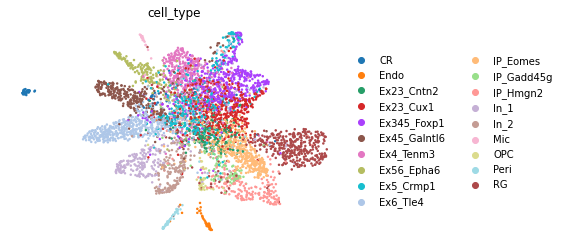

In [24]:
sc.pl.umap(latent, color='cell_type', frameon=False)